In [1]:
MODEL_FILE_NAME = "ConvNeXtLarge"

#Mount GoogleDrive

In [2]:
from google.colab import drive
drive.mount('/gdrive')
%cd /gdrive/My Drive/Colab Consegna

Drive already mounted at /gdrive; to attempt to forcibly remount, call drive.mount("/gdrive", force_remount=True).
/gdrive/My Drive/Colab Consegna


#Import Libraries

In [3]:
import numpy as np
from numpy import load
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, confusion_matrix
from tensorflow.keras.preprocessing.image import ImageDataGenerator
# Import tensorflow
%pip install keras-cv
import keras_cv
import tensorflow as tf
from tensorflow import keras as tfk
from keras import layers as tfkl
from keras.applications.efficientnet import preprocess_input
import logging

tf.autograph.set_verbosity(0)
tf.get_logger().setLevel(logging.ERROR)
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)
print(tf.__version__)

from tensorflow import keras

# Display
from IPython.display import Image, display
import matplotlib.pyplot as plt
import matplotlib.cm as cm

seed = 42
np.random.seed(seed=seed)

Using TensorFlow backend
2.14.0


#Load original cleaned dataset


In [4]:
#Load original cleaned dataset
#Range value [0,1]
X = load("X_cleaned.npy")
y = load("y_cleaned.npy")

**Dataset splitting**

In [5]:
X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, random_state=seed, test_size=.1, stratify=np.argmax(y,axis=1))

X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=len(y_test), stratify=np.argmax(y_train_val,axis=1),random_state=seed)


del X_train_val
del y_train_val

# Print shapes of the datasets
print(f"X_train shape: {X_train.shape}, y_train shape: {y_train.shape}")
print(f"X_val shape: {X_val.shape}, y_val shape: {y_val.shape}")
print(f"X_test shape: {X_test.shape}, y_test shape: {y_test.shape}")

print(f"X_test dtype: {X_test.dtype}, y_test dtype: {y_test.dtype}")

X_train shape: (4002, 96, 96, 3), y_train shape: (4002, 2)
X_val shape: (501, 96, 96, 3), y_val shape: (501, 2)
X_test shape: (501, 96, 96, 3), y_test shape: (501, 2)
X_test dtype: float32, y_test dtype: float32


**Plot some examples**

/usr/local/lib/python3.10/dist-packages/matplotlib/text.py:1279: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if s != self._text:


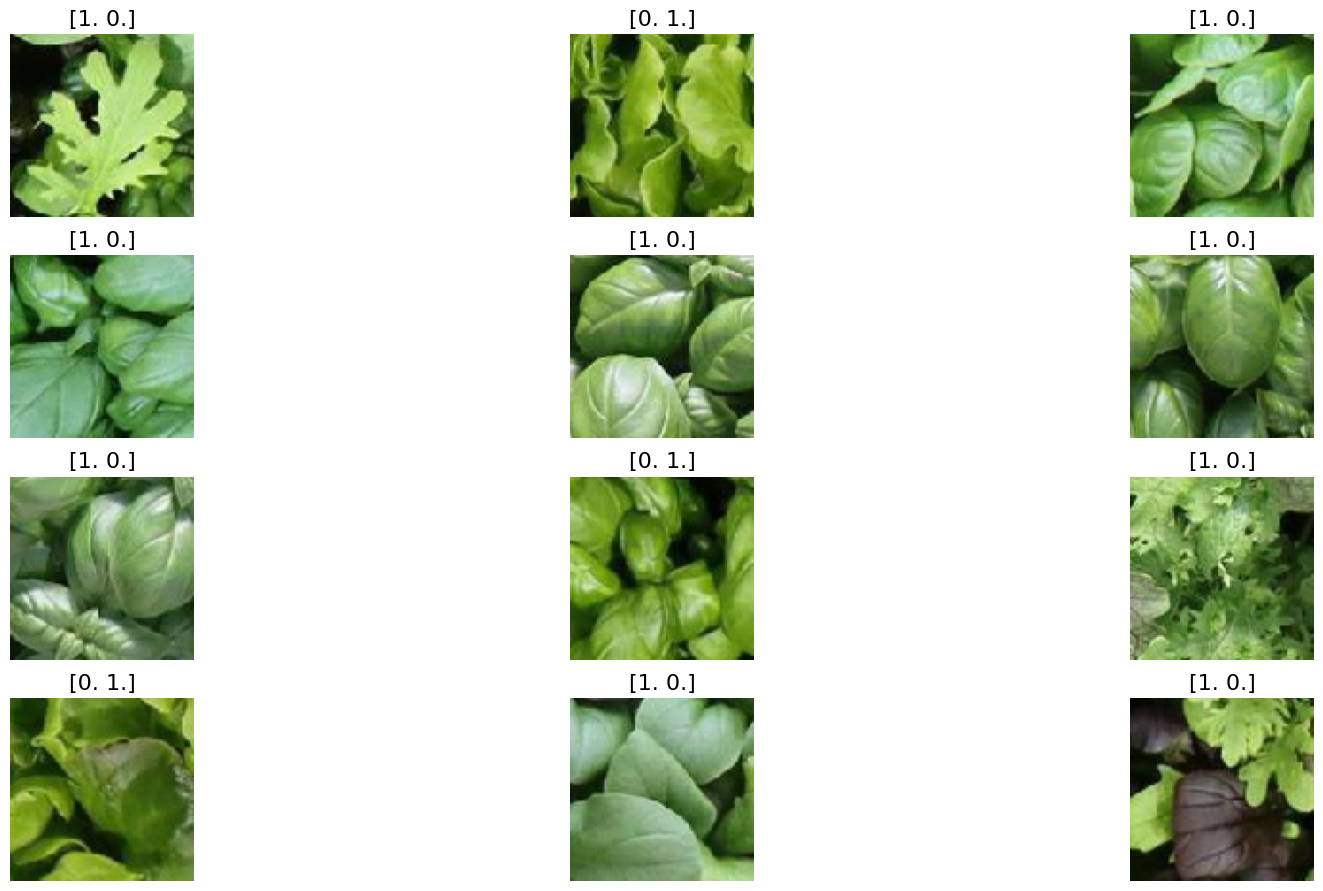

In [6]:
num_img = 12
amountOfRow = 4

width = height = X[0].shape[0]

fig, axes = plt.subplots(amountOfRow, num_img//amountOfRow, figsize=(20, 9))
for i in range(num_img):
    ax = axes[i%amountOfRow, i%num_img//amountOfRow]
    ax.imshow(X[i])  # Display clipped item images
    ax.text(width/2,-5, y[i],fontsize=16, ha='center')
    ax.axis('off')
plt.tight_layout()
plt.show()

#HYPERPARAMETERS

In [7]:
dropout_rate = 0.45
learning_rate_fine_tuning_phase = 5e-5
weight_decay_fine_tuning_phase = 3e-5
percentage_of_locked_layer_in_fine_tuning = 0.8

doubleLayerInClassification=False
secondLayerUnits = 128

In [8]:
# Define input shape, output shape, batch size, and number of epochs
input_shape = X_train.shape[1:]
output_shape = y_train.shape[1:]
batch_size = 32
epochs = 1000

# Print input shape, batch size, and number of epochs
print(f"Input Shape: {input_shape}, Output Shape: {output_shape}, Batch Size: {batch_size}, Epochs: {epochs}")

Input Shape: (96, 96, 3), Output Shape: (2,), Batch Size: 32, Epochs: 1000


#Build The Model

In [ ]:
def build_Model(input_shape,output_shape=2,dropout=0.5,learning_rate=learning_rate_fine_tuning_phase,weight_decay=weight_decay_fine_tuning_phase):

  #Preprocessing layer
  preprocessing = tf.keras.Sequential([
        #tfkl.RandomTranslation(0.1,0.1, seed=seed),
        tfkl.RandomZoom(0.1, seed=seed),
        tfkl.RandomRotation(0.25, seed=seed),
        tfkl.RandomFlip("horizontal", seed=seed),
        #tfkl.GaussianNoise(0.02,seed=seed),
        #tfkl.RandomBrightness(0.15,value_range=(0,255), seed=seed)
        #tf.keras.layers.Rescaling(1./127.5, offset=-1), # To be used for nets which require input to be in range [-1 , 1]
        #tf.keras.layers.Rescaling(1./255), # To be used for nets which require input to be in range [0 , 1]
    ], name='preprocessing')

  #Import the supernet
  importedNet = tf.keras.applications.ConvNeXtLarge(
    include_top=False,
    weights="imagenet",
    input_shape=input_shape,
    pooling="avg",
  )

  #Set a name to be able to recover the layer
  importedNet._name = "importedNetworkLayer"

  #Unlock some layers for FT
  importedNet.trainable = False



  #Building the model layers
  inputs = tfk.Input(shape=input_shape)

  preprocessing = preprocessing(inputs)

  x = importedNet(preprocessing)

  if doubleLayerInClassification:
    if dropout_rate != 0:
      x = tfkl.Dropout(dropout)(x)
    x = tfkl.BatchNormalization()(x)
    x = tfkl.Dense(secondLayerUnits, activation="relu")(x)

  if dropout_rate != 0:
    x = tfkl.Dropout(dropout)(x)
  outputs = tfkl.Dense(output_shape, activation="softmax")(x)

  #Create the model
  model = tfk.Model(inputs=inputs,outputs = outputs)

  #Compile
  model.compile(loss = tfk.losses.CategoricalCrossentropy(),optimizer=tfk.optimizers.AdamW(learning_rate=learning_rate,weight_decay=weight_decay),metrics=['accuracy'])

  model.summary()

  return model

**Instantiating the model**

In [ ]:
myModel = build_Model(input_shape=input_shape,weight_decay=weight_decay_fine_tuning_phase,learning_rate=learning_rate_fine_tuning_phase,dropout=dropout_rate)

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 96, 96, 3)]       0         
                                                                 
 preprocessing (Sequential)  (None, 96, 96, 3)         0         
                                                                 
 importedNetworkLayer (Func  (None, 1536)              196230336 
 tional)                                                         
                                                                 
 dropout (Dropout)           (None, 1536)              0         
                                                                 
 dense (Dense)               (None, 2)                 3074      
                                                                 
Total params: 196233410 (748.57 MB)
Trainable params: 3074 (12.01 KB)
Non-trainable params: 196230336 (748.56 MB)
_____________

In [ ]:
for layer in myModel.layers:
  layer.trainable = True

importedNetLayer = myModel.get_layer("importedNetworkLayer")

totLevelsInImportedNet = len(importedNetLayer.layers)

print(f"Total layers in supernet: {totLevelsInImportedNet}")

locked = int(percentage_of_locked_layer_in_fine_tuning * totLevelsInImportedNet)
unlocked = totLevelsInImportedNet - locked

print(f"Total unlocked layers in supernet: {unlocked} / {totLevelsInImportedNet}")

for layer in importedNetLayer.layers[0:locked]:
  layer.trainable = False

for layer in importedNetLayer.layers[unlocked:]:
  layer.trainable = True

Total layers in supernet: 296
Total unlocked layers in supernet: 60 / 296


In [ ]:
myModel.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 96, 96, 3)]       0         
                                                                 
 preprocessing (Sequential)  (None, 96, 96, 3)         0         
                                                                 
 importedNetworkLayer (Func  (None, 1536)              196230336 
 tional)                                                         
                                                                 
 dropout (Dropout)           (None, 1536)              0         
                                                                 
 dense (Dense)               (None, 2)                 3074      
                                                                 
Total params: 196233410 (748.57 MB)
Trainable params: 185459714 (707.47 MB)
Non-trainable params: 10773696 (41.10 MB)
_________

In [ ]:
myModel.compile(loss = tfk.losses.CategoricalCrossentropy(),optimizer=tfk.optimizers.AdamW(learning_rate=learning_rate_fine_tuning_phase,weight_decay=weight_decay_fine_tuning_phase),metrics=['accuracy'])


**Defining the callbacks**

In [ ]:
modelEarlyStopping = tfk.callbacks.EarlyStopping(monitor='val_accuracy', patience=15, restore_best_weights=True, mode='max')

# Define two callback functions for early stopping and learning rate reduction
callbacks=[
    modelEarlyStopping,
    tfk.callbacks.ReduceLROnPlateau(monitor="val_accuracy", factor=0.5, patience=10, min_lr=1e-5, mode='max')
]

# Print the defined callbacks
print("Callbacks:")
for callback in callbacks:
    print(callback)

Callbacks:


#Training

In [ ]:
# Train the model
myHistory = myModel.fit(
    x = (X_train*255), # We need to apply the preprocessing thought for the MobileNetV2 network
    y = y_train,
    batch_size = batch_size,
    epochs = epochs,
    validation_data = (X_val*255, y_val), # We need to apply the preprocessing thought for the original network
    callbacks = callbacks
).history

Epoch 1/1000
126/126 [==============================] - 177s 754ms/step - loss: 0.5242 - accuracy: 0.7794 - val_loss: 0.3970 - val_accuracy: 0.8323 - lr: 5.0000e-05
Epoch 2/1000
126/126 [==============================] - 75s 597ms/step - loss: 0.3084 - accuracy: 0.8708 - val_loss: 0.2349 - val_accuracy: 0.9042 - lr: 5.0000e-05
Epoch 3/1000
126/126 [==============================] - 74s 586ms/step - loss: 0.2211 - accuracy: 0.9128 - val_loss: 0.3050 - val_accuracy: 0.8703 - lr: 5.0000e-05
Epoch 4/1000
126/126 [==============================] - 76s 600ms/step - loss: 0.1449 - accuracy: 0.9405 - val_loss: 0.2970 - val_accuracy: 0.8982 - lr: 5.0000e-05
Epoch 5/1000
126/126 [==============================] - 76s 601ms/step - loss: 0.1294 - accuracy: 0.9485 - val_loss: 0.2530 - val_accuracy: 0.9042 - lr: 5.0000e-05
Epoch 6/1000
126/126 [==============================] - 76s 601ms/step - loss: 0.1263 - accuracy: 0.9483 - val_loss: 0.2468 - val_accuracy: 0.9022 - lr: 5.0000e-05
Epoch 7/1000
12

#Inference

In [ ]:
test_predictions = myModel.predict(X_test*255, verbose=0)

In [ ]:
accuracy = accuracy_score(np.argmax(y_test, axis=-1), np.argmax(test_predictions, axis=-1))
precision = precision_score(np.argmax(y_test, axis=-1), np.argmax(test_predictions, axis=-1), average='macro')
recall = recall_score(np.argmax(y_test, axis=-1), np.argmax(test_predictions, axis=-1), average='macro')
f1 = f1_score(np.argmax(y_test, axis=-1), np.argmax(test_predictions, axis=-1), average='macro')

print('Accuracy:', accuracy.round(4))
print('Precision:', precision.round(4))
print('Recall:', recall.round(4))
print('F1:', f1.round(4))

Accuracy: 0.9421
Precision: 0.9417
Recall: 0.9351
F1: 0.9382


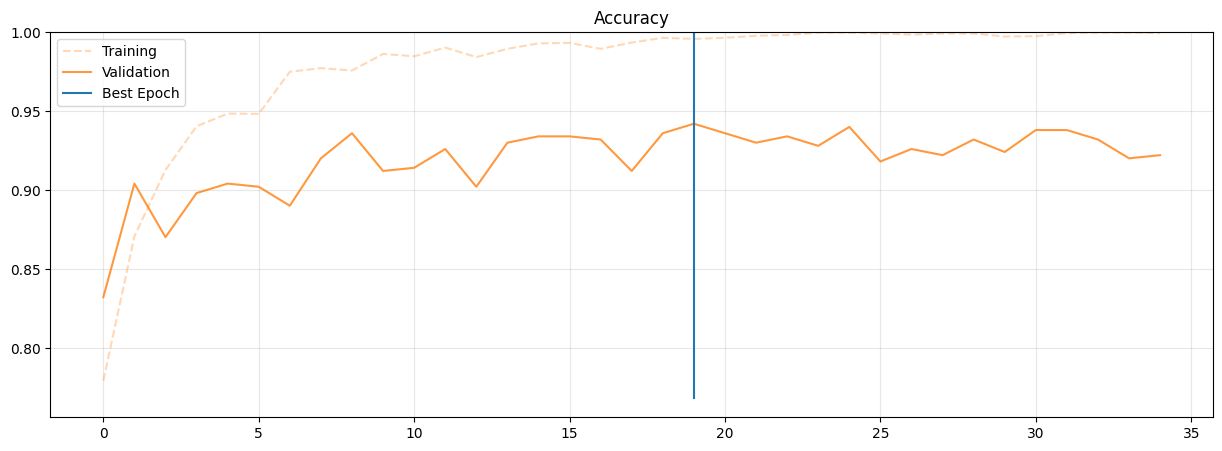

In [31]:
# Plot the re-trained and the transfer learning MobileNetV2 training histories
plt.figure(figsize=(15,5))
plt.plot(myHistory['accuracy'], label="Training",alpha=.3, color='#ff7f0e', linestyle='--')
plt.plot(myHistory['val_accuracy'], label='Validation', alpha=.8, color='#ff7f0e')
plt.plot([model_early_stopping.best_epoch,model_early_stopping.best_epoch], plt.ylim(), label='Best Epoch')
plt.ylim([min(plt.ylim()),1])
plt.legend(loc='upper left')
plt.title('Accuracy')
plt.grid(alpha=.3)
plt.show()

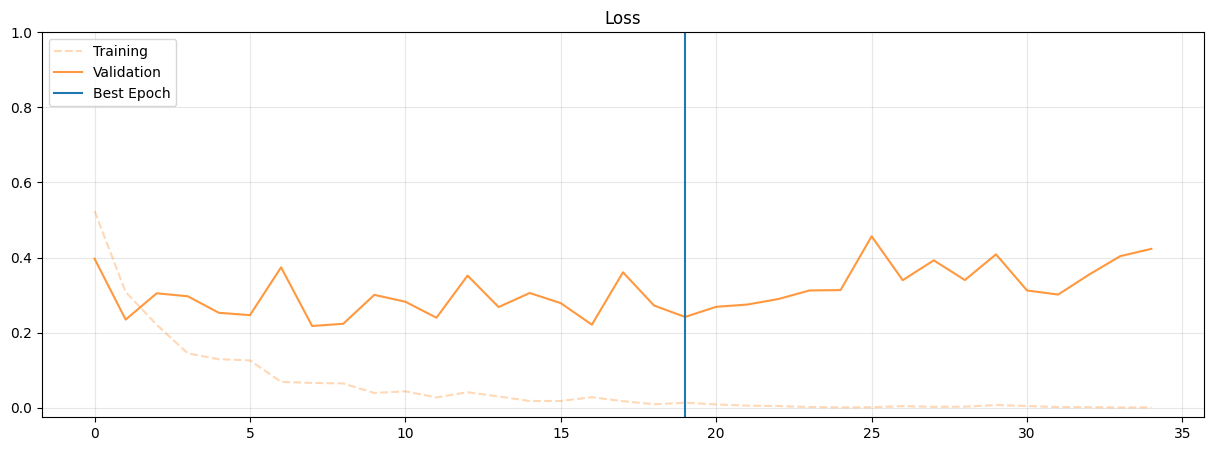

In [32]:
# Plot the re-trained and the transfer learning MobileNetV2 training histories
plt.figure(figsize=(15,5))
plt.plot(myHistory['loss'], label="Training",alpha=.3, color='#ff7f0e', linestyle='--')
plt.plot(myHistory['val_loss'], label='Validation', alpha=.8, color='#ff7f0e')
plt.ylim([min(plt.ylim()),1])
plt.plot([model_early_stopping.best_epoch,model_early_stopping.best_epoch], plt.ylim(), label='Best Epoch')
plt.legend(loc='upper left')
plt.title('Loss')
plt.grid(alpha=.3)
plt.show()

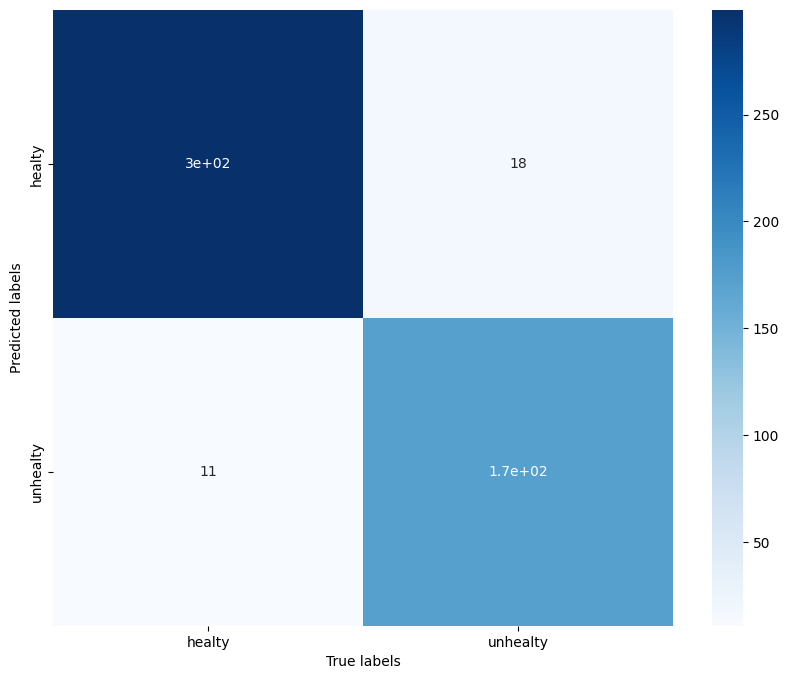

In [ ]:
%pip install seaborn
import seaborn as sns
cm = confusion_matrix(np.argmax(y_test, axis=-1), np.argmax(test_predictions, axis=-1))

# Plot the confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm.T, xticklabels=list(('healty','unhealty')), yticklabels=list(('healty','unhealty')), cmap='Blues', annot=True)
plt.xlabel('True labels')
plt.ylabel('Predicted labels')
plt.show()

#Saving The Model

In [ ]:
myModel.save(MODEL_FILE_NAME)
del myModel

#Reloading Model for GRAD-CAM

In [9]:
myModel = tfk.models.load_model(MODEL_FILE_NAME)

**Get Predictions on test set**


In [10]:
test_predictions = myModel.predict(X_test*255, verbose=0)

In [12]:
binary_classes = np.zeros_like(test_predictions)
binary_classes[np.arange(len(test_predictions)), np.argmax(test_predictions, axis=1)] = 1

indices_diff = np.where((binary_classes != y_test).any(axis=1))[0]
indices_equal = np.where((binary_classes == y_test).any(axis=1))[0]

In [13]:
misclassified = X_test[indices_diff]
correctlyClassified = X_test[indices_equal]

**Plot misclassified**

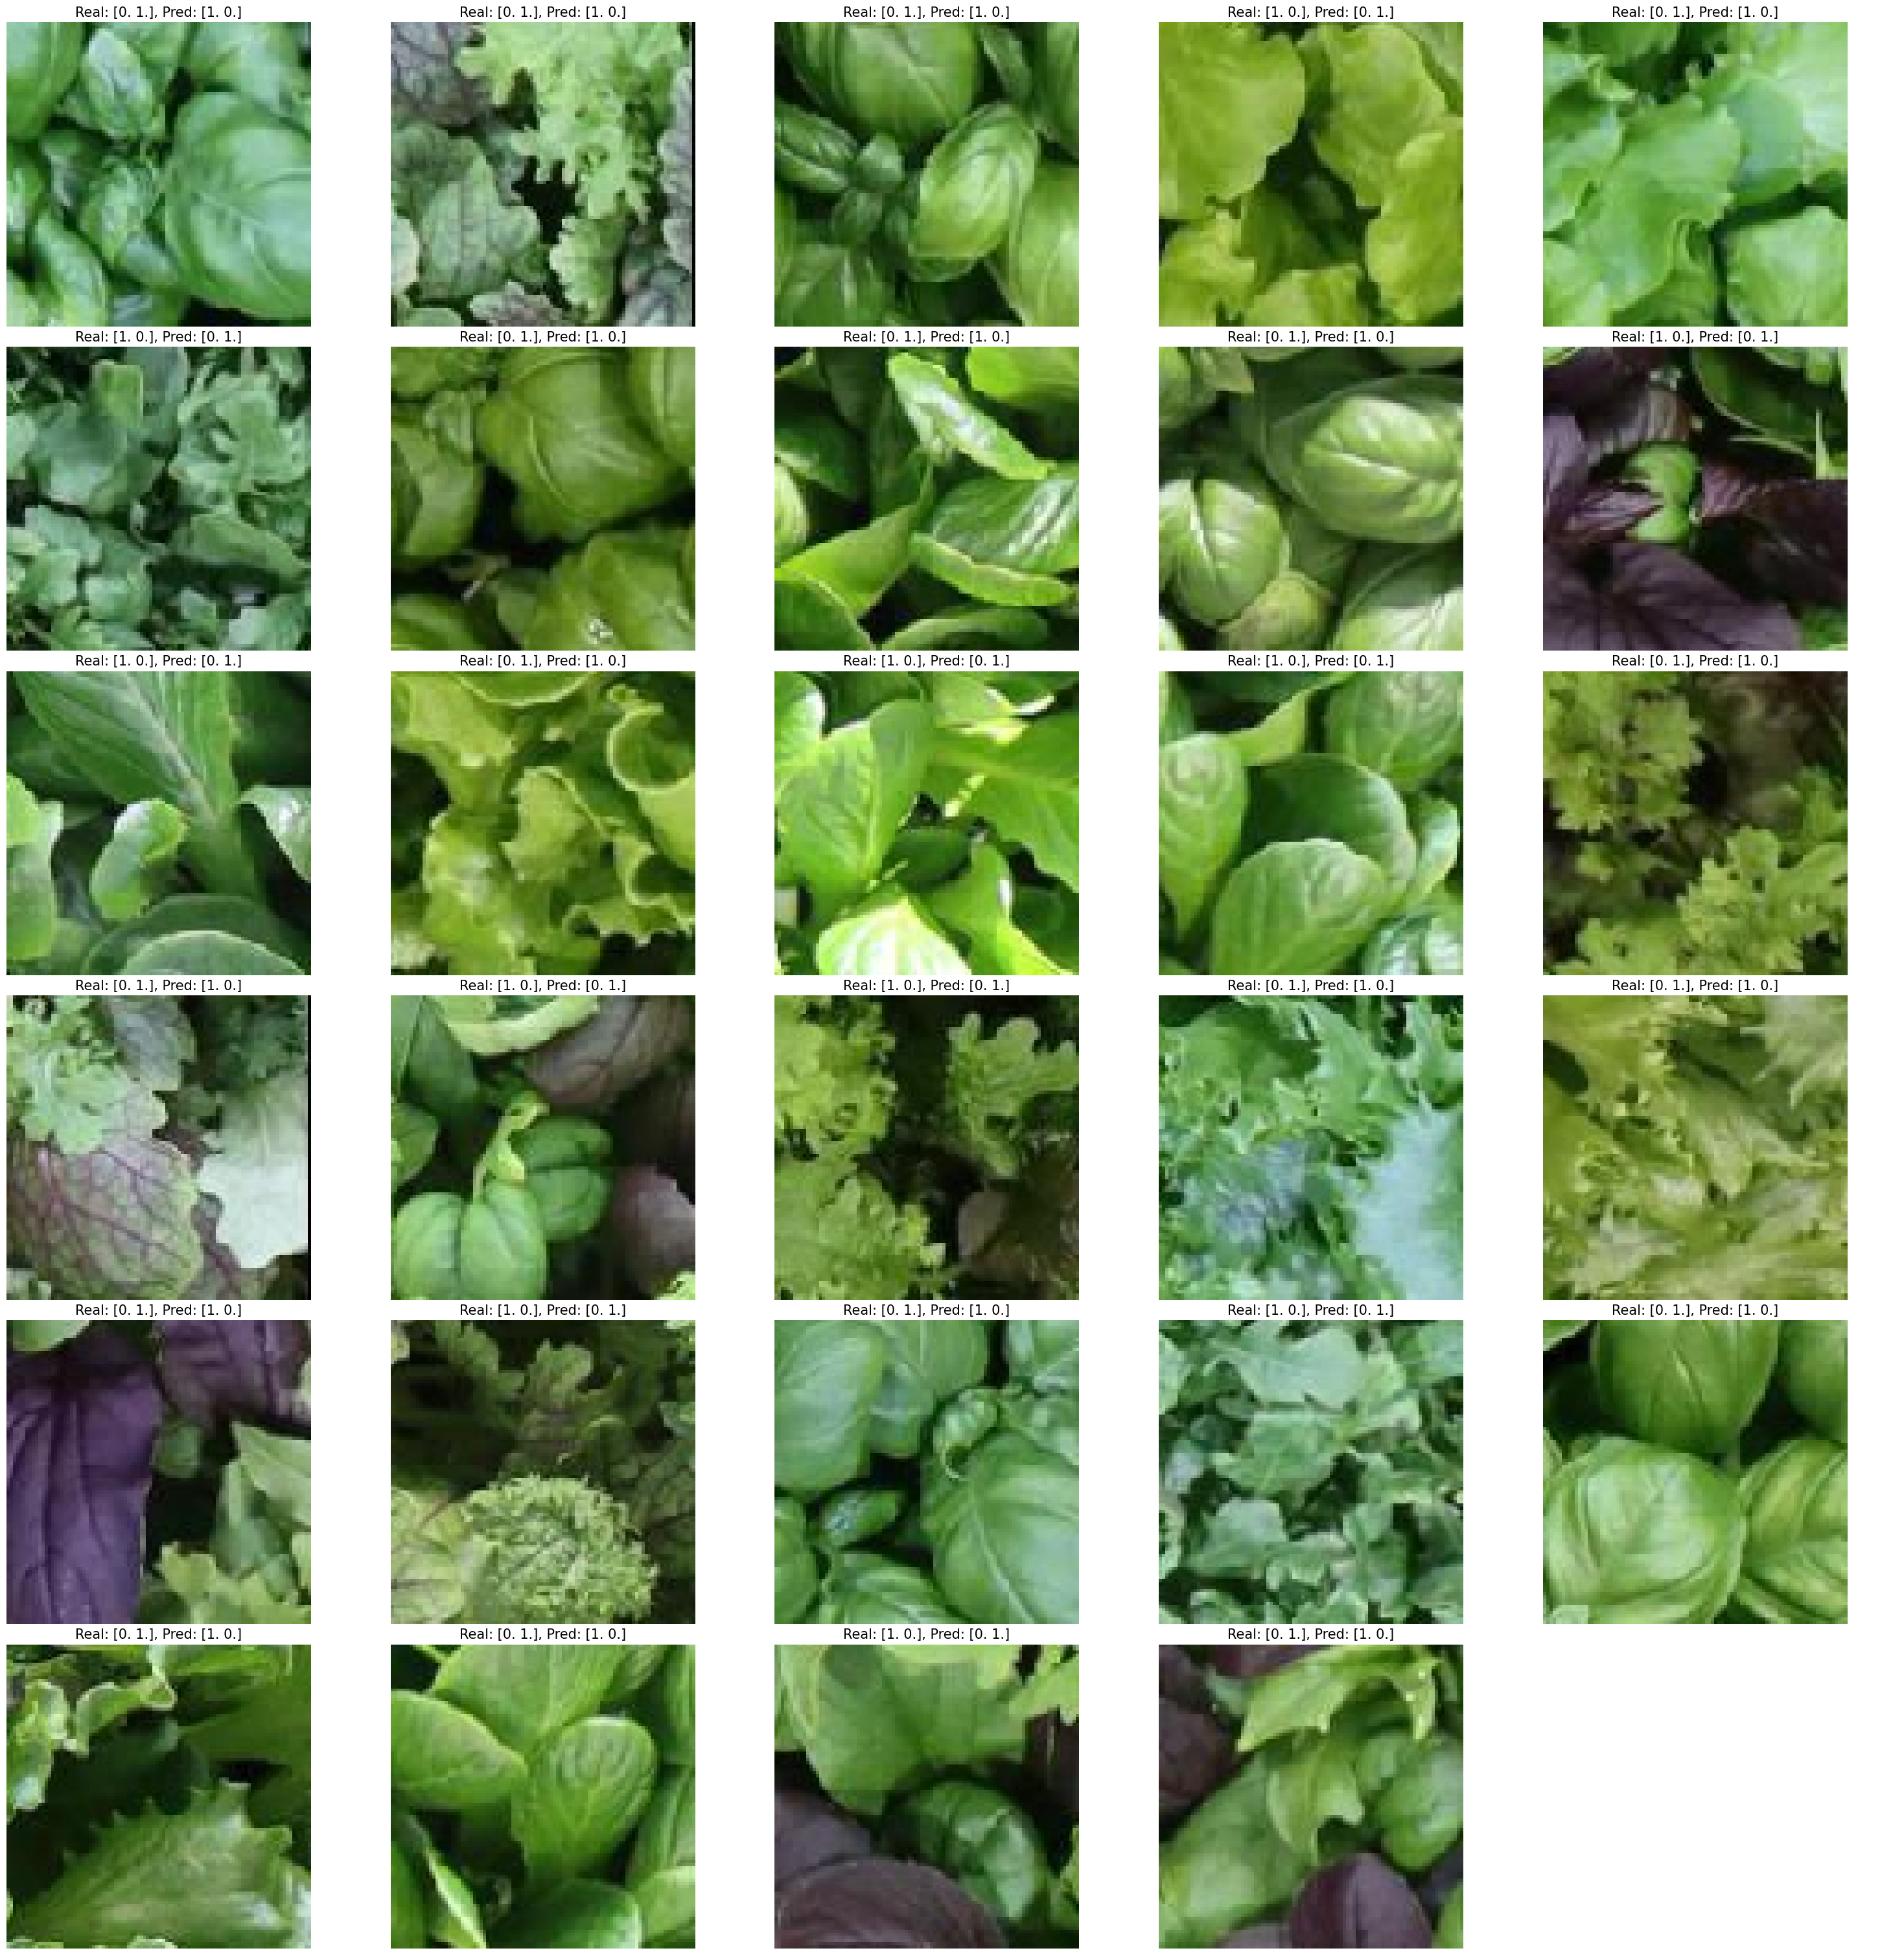

In [14]:
num_img = len(misclassified)
num_cols = min(num_img, 5)  # Set the number of columns to 5

num_rows = (num_img - 1) // num_cols + 1  # Calculate the number of rows needed

fig, axes = plt.subplots(num_rows, num_cols, figsize=(30, 30))

for i in range(num_img):
    ax = axes[i // num_cols, i % num_cols]
    ax.imshow(np.clip(misclassified[i], 0, 255))
    ax.set_title(f"Real: {y_test[indices_diff[i]]}, Pred: {binary_classes[indices_diff[i]]}", fontsize=15)
    ax.axis('off')

# Hide any empty subplots
for i in range(num_img, num_rows * num_cols):
    ax = axes[i // num_cols, i % num_cols]
    ax.axis('off')

plt.tight_layout(pad=0.1, h_pad=0.5, w_pad=0.1)
plt.show()

**Define helper functions**

In [15]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
import matplotlib.cm as cm

def make_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index=None):
    # First, we create a model that maps the input image to the activations
    # of the last conv layer as well as the output predictions
    grad_model = keras.models.Model(
        model.inputs, [model.get_layer(last_conv_layer_name).output, model.output]
    )

    # Then, we compute the gradient of the top predicted class for our input image
    # with respect to the activations of the last conv layer
    with tf.GradientTape() as tape:
        last_conv_layer_output, preds = grad_model(img_array)
        if pred_index is None:
            pred_index = tf.argmax(preds[0])
        class_channel = preds[:, pred_index]

    # This is the gradient of the output neuron (top predicted or chosen)
    # with regard to the output feature map of the last conv layer
    grads = tape.gradient(class_channel, last_conv_layer_output)

    # This is a vector where each entry is the mean intensity of the gradient
    # over a specific feature map channel
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    # We multiply each channel in the feature map array
    # by "how important this channel is" with regard to the top predicted class
    # then sum all the channels to obtain the heatmap class activation
    last_conv_layer_output = last_conv_layer_output[0]
    heatmap = last_conv_layer_output @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)

    # For visualization purpose, we will also normalize the heatmap between 0 & 1
    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    return heatmap.numpy()

def save_and_display_gradcam(img, heatmap, cam_path="cam.jpg", alpha=0.4):
    # Load the original image
    img = keras.utils.img_to_array(img)

    # Rescale heatmap to a range 0-255
    heatmap = np.uint8(255 * heatmap)

    # Use jet colormap to colorize heatmap
    #jet = cm.get_cmap("jet")
    jet = cm.get_cmap("viridis")

    # Use RGB values of the colormap
    jet_colors = jet(np.arange(256))[:, :3]
    jet_heatmap = jet_colors[heatmap]

    # Create an image with RGB colorized heatmap
    jet_heatmap = keras.utils.array_to_img(jet_heatmap)
    jet_heatmap = jet_heatmap.resize((img.shape[1], img.shape[0]))
    jet_heatmap = keras.utils.img_to_array(jet_heatmap)

    # Superimpose the heatmap on original image
    superimposed_img = jet_heatmap * alpha + img
    superimposed_img = keras.utils.array_to_img(superimposed_img)

    # Save the superimposed image
    superimposed_img.save(cam_path)


    #finalImages.append(superimposed_img)

    # Display Grad CAM
    #display(Image(cam_path, width=200, height=80))

    return superimposed_img

In [16]:

preds = myModel.predict(misclassified*255)


# Generate class activation heatmap
heatmaps = []
for img in misclassified:
    img = np.expand_dims(img, axis=0)
    heatmaps.append(make_gradcam_heatmap(img*255, myModel.get_layer("importedNetworkLayer"), "convnext_large_stage_3_block_2_depthwise_conv"))

finalMisclassifiedImages = []

for i in range(len(misclassified)):
    finalMisclassifiedImages.append(save_and_display_gradcam(misclassified[i]*255, heatmaps[i]))

1/1 [==============================] - 5s 5s/step


<ipython-input-15-372d79e7c904>:49: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  jet = cm.get_cmap("viridis")


**Plot misclassified maps**

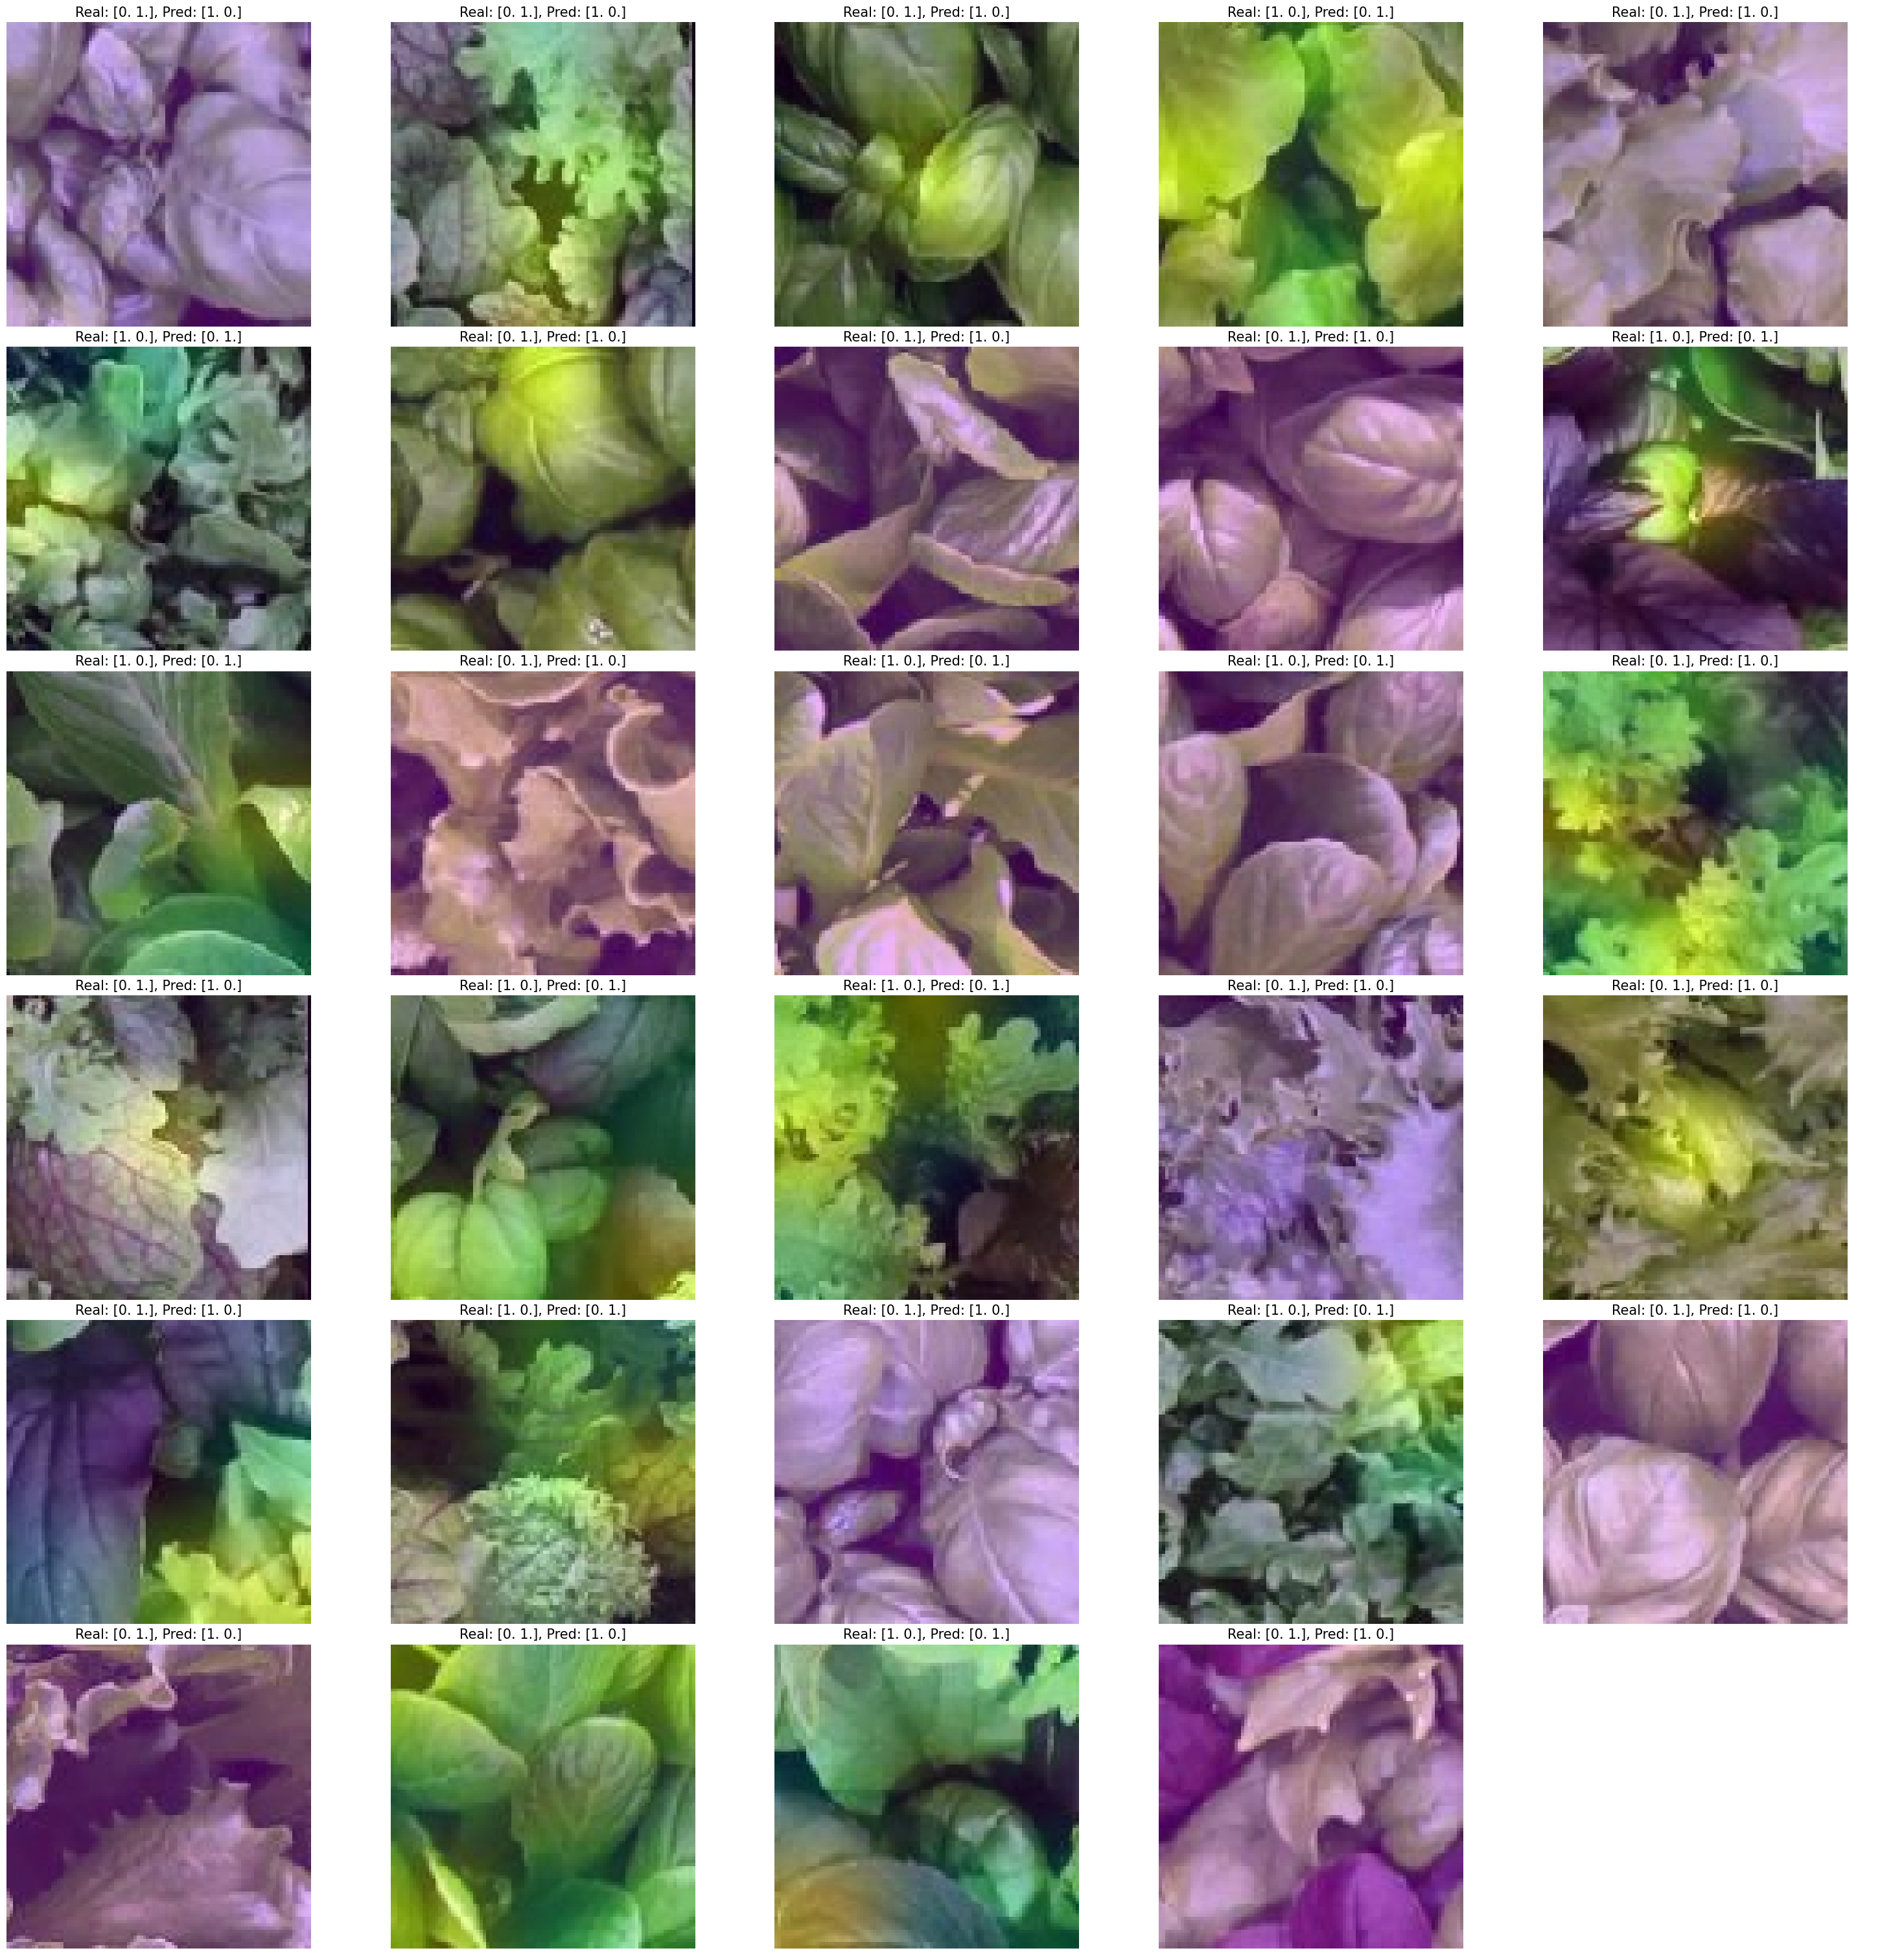

In [17]:
num_img = len(finalMisclassifiedImages)
num_cols = min(num_img, 5)  # Set the number of columns to 5

num_rows = (num_img - 1) // num_cols + 1  # Calculate the number of rows needed

fig, axes = plt.subplots(num_rows, num_cols, figsize=(30, 30))

for i in range(num_img):
    ax = axes[i // num_cols, i % num_cols]

    # Convert the IPython Image object to a NumPy array and display it
    img_array = np.array(finalMisclassifiedImages[i])
    ax.imshow(img_array)

    ax.set_title(f"Real: {y_test[indices_diff[i]]}, Pred: {binary_classes[indices_diff[i]]}", fontsize=15)
    ax.axis('off')

# Hide any empty subplots
for i in range(num_img, num_rows * num_cols):
    ax = axes[i // num_cols, i % num_cols]
    ax.axis('off')

plt.tight_layout(pad=0.1, h_pad=0.5, w_pad=0.1)
plt.show()

**Calculate Correct maps**

In [18]:
correctPreditcions = test_predictions[indices_equal]

In [21]:
# Prepare image
img_array = correctlyClassified

#selecting top 36
img_array = img_array[:36]

print(f"Correctly classified: {len(indices_equal)}")

# Remove last layer's softmax
myModel.get_layer("importedNetworkLayer").layers[-1].activation = None
preds = myModel.get_layer("importedNetworkLayer").predict(img_array*255)

preds = myModel.predict(img_array*255)

# Print what the top predicted class is
print(f"Len original predictions: {len(indices_equal)}")

finalCorrectImages = []

heatmapsCorrect = []
for img in img_array:
# Generate class activation heatmap
    img = np.expand_dims(img, axis=0)
    heatmapsCorrect.append(make_gradcam_heatmap(img*255, myModel.get_layer("importedNetworkLayer"), "convnext_large_stage_3_block_2_depthwise_conv"))

for i in range(len(img_array)):
    finalCorrectImages.append(save_and_display_gradcam(img_array[i]*255, heatmapsCorrect[i]))

Correctly classified: 472
2/2 [==============================] - 0s 129ms/step
Len original predictions: 472


<ipython-input-15-372d79e7c904>:49: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  jet = cm.get_cmap("viridis")


**Plot correct maps**

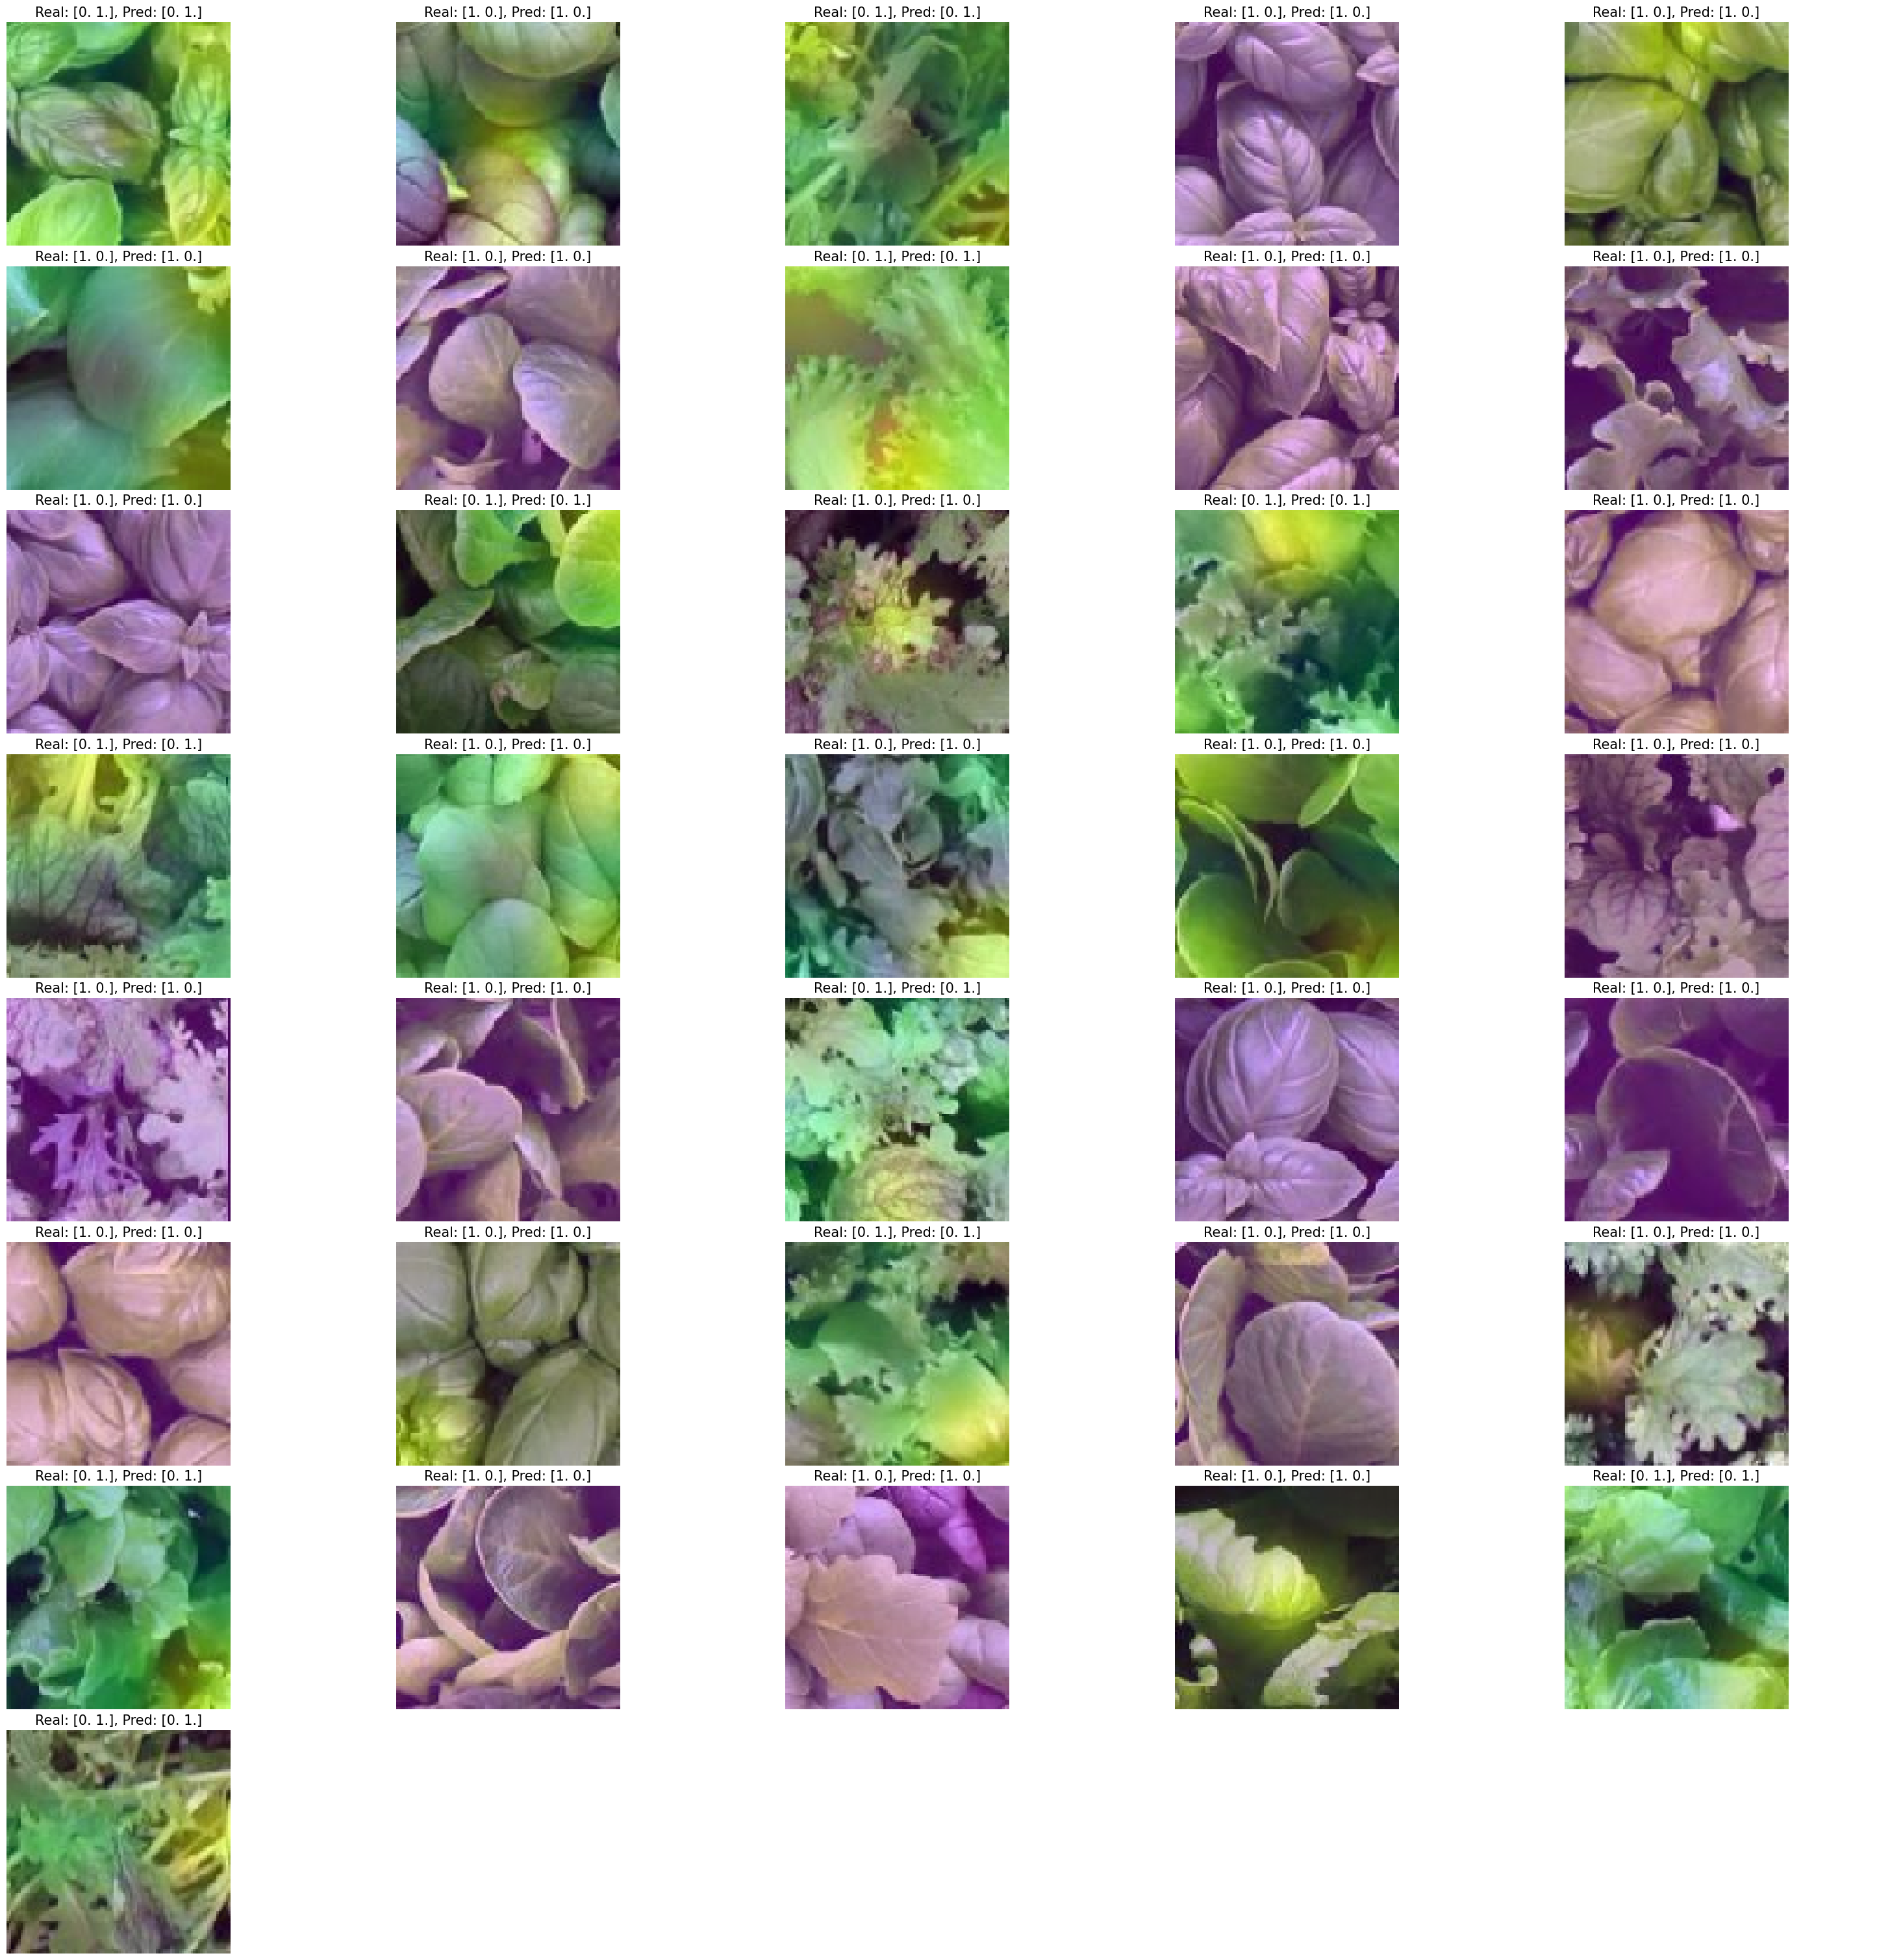

In [22]:
import numpy as np
import matplotlib.pyplot as plt

num_img = len(finalCorrectImages)
num_cols = min(num_img, 5)  # Set the number of columns to 5

num_rows = (num_img - 1) // num_cols + 1  # Calculate the number of rows needed

fig, axes = plt.subplots(num_rows, num_cols, figsize=(30, 30))

for i in range(num_img):
    ax = axes[i // num_cols, i % num_cols]

    img_array = np.array(finalCorrectImages[i])
    ax.imshow(img_array)
    ax.set_title(f"Real: {y_test[indices_equal[i]]}, Pred: {binary_classes[indices_equal[i]]}", fontsize=15)

    ax.axis('off')

# Hide any empty subplots
for i in range(num_img, num_rows * num_cols):
    ax = axes[i // num_cols, i % num_cols]
    ax.axis('off')

plt.tight_layout(pad=0.1, h_pad=0.5, w_pad=0.1)
plt.show()